In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import re
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mck_parser(filename):
    """Read a *.mck formated file and convert it to a pandas
    hierarchical indexed DataFrame object.

    Args:
        filename (string): the name of the mck-file to convert.
    Returns:
        pandas.DataFrame -- containing the converted data.

    """

    date_spec = {'FetchTime': [1, 2]}
    header_spec = ['No', 'Time', 'Date', 'MoistAve', 'MatTemp', 'TDRConduct',
                   'TDRAve', 'DeltaCount', 'tpAve', 'Moist1', 'Moist2',
                   'Moist3', 'Moist4', 'TDR1', 'TDR2', 'TDR3', 'TDR4']
    df = pd.read_csv(filename, comment=';', skiprows=8, names=header_spec,
                     sep='\s\s+', parse_dates=date_spec, engine='python',
                     na_values=['-1.0', '-1.00'])
    data = []
    for d in range(1,5):
        temp = df.ix[:, ['FetchTime', 'No', 'MoistAve', 'MatTemp',
                         'TDRConduct', 'TDRAve', 'DeltaCount', 'tpAve',
                         'Moist%d' % d, 'TDR%d' % d]]
        temp.columns = ['FetchTime', 'No', 'MoistAve', 'MatTemp', 'TDRConduct',
                        'TDRAve', 'DeltaCount', 'tpAve', 'RawMoist', 'RawTDR']
        temp['MeasureIdx'] = d
        data.append(temp)

    df = pd.concat(data).sort_index(by=['No', 'MeasureIdx'])
    df['No'] = range(0, len(df))
    return df.set_index(['FetchTime', 'MeasureIdx', 'No'])

In [4]:
df = mck_parser('data/MeasureCK32450-20120925165511.mck')

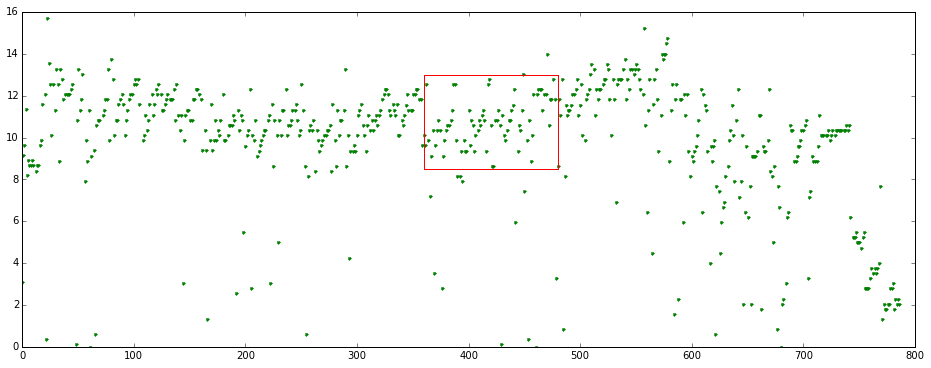

In [5]:
# Data
plt.figure(figsize=(16, 6))
plt.plot(df.RawMoist.values, 'g.')
plt.plot([360,360], [8.5,13], 'r-')
plt.plot([480,480], [8.5,13], 'r-')
plt.plot([480,360], [13,13], 'r-')
plt.plot([480,360], [8.5,8.5], 'r-')

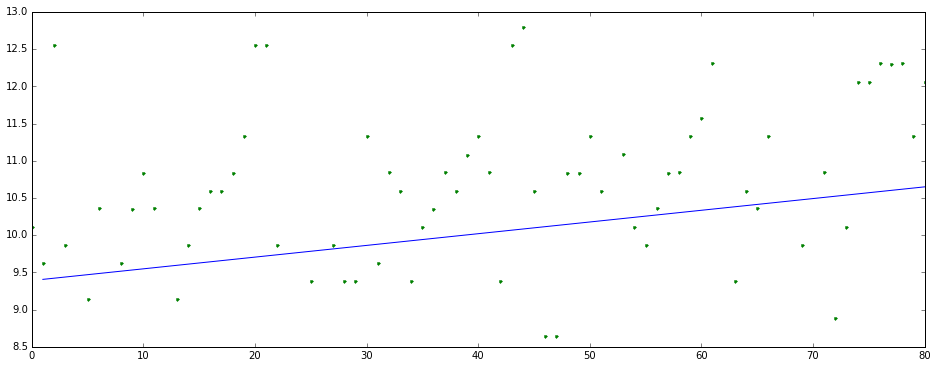

In [6]:
# Box
plt.figure(figsize=(16, 6))
box = df[360:480].query('RawMoist>0')
#box = df[360:480].query('RawMoist>8.5').query('RawMoist<13')
plt.plot(box.RawMoist, 'g.')
plt.axis([0, 80, 8.5, 13])
box['rang'] = range(1, len(box) + 1)

# Trend
z = numpy.polyfit(box.rang, box.RawMoist, 1)
p = numpy.poly1d(z)
pylab.plot(box.rang, p(box.rang),'b-')

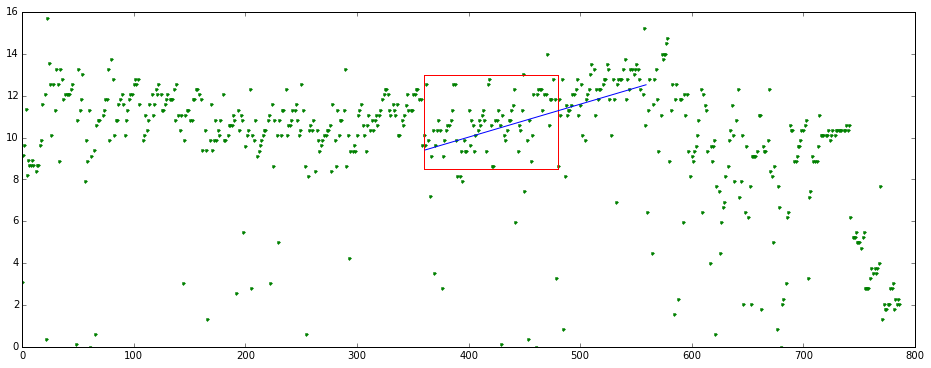

In [7]:
# Data
plt.figure(figsize=(16, 6))
plt.plot(df.RawMoist.values, 'g.')

# Box
plt.plot([360,360], [8.5,13], 'r-')
plt.plot([480,480], [8.5,13], 'r-')
plt.plot([480,360], [13,13], 'r-')
plt.plot([480,360], [8.5,8.5], 'r-')

# Trend
x = [i+360 for i in range(1,200)]
y = p([i for i in range(1,200)])
pylab.plot(x, y, 'b-')

### numpy.polyfit() - A least squares polynomial fit.

    Fit a polynomial ``p(x) = p[0] * x**deg + ... + p[deg]`` of degree `deg`
    to points `(x, y)`. Returns a vector of coefficients `p` that minimises
    the squared error.

    Parameters
    ----------
    x : array_like, shape (M,)
        x-coordinates of the M sample points ``(x[i], y[i])``.
    y : array_like, shape (M,) or (M, K)
        y-coordinates of the sample points. Several data sets of sample
        points sharing the same x-coordinates can be fitted at once by
        passing in a 2D-array that contains one dataset per column.
    deg : int
        Degree of the fitting polynomial
    rcond : float, optional
        Relative condition number of the fit. Singular values smaller than
        this relative to the largest singular value will be ignored. The
        default value is len(x)*eps, where eps is the relative precision of
        the float type, about 2e-16 in most cases.
    full : bool, optional
        Switch determining nature of return value. When it is False (the
        default) just the coefficients are returned, when True diagnostic
        information from the singular value decomposition is also returned.
    w : array_like, shape (M,), optional
        weights to apply to the y-coordinates of the sample points.
    cov : bool, optional
        Return the estimate and the covariance matrix of the estimate
        If full is True, then cov is not returned.

    Returns
    -------
    p : ndarray, shape (M,) or (M, K)
        Polynomial coefficients, highest power first.  If `y` was 2-D, the
        coefficients for `k`-th data set are in ``p[:,k]``.

    residuals, rank, singular_values, rcond :
        Present only if `full` = True.  Residuals of the least-squares fit,
        the effective rank of the scaled Vandermonde coefficient matrix,
        its singular values, and the specified value of `rcond`. For more
        details, see `linalg.lstsq`.

    V : ndarray, shape (M,M) or (M,M,K)
        Present only if `full` = False and `cov`=True.  The covariance
        matrix of the polynomial coefficient estimates.  The diagonal of
        this matrix are the variance estimates for each coefficient.  If y
        is a 2-D array, then the covariance matrix for the `k`-th data set
        are in ``V[:,:,k]``


    Warns
    -----
    RankWarning
        The rank of the coefficient matrix in the least-squares fit is
        deficient. The warning is only raised if `full` = False.

        The warnings can be turned off by

        >>> import warnings
        >>> warnings.simplefilter('ignore', np.RankWarning)

    See Also
    --------
    polyval : Computes polynomial values.
    linalg.lstsq : Computes a least-squares fit.
    scipy.interpolate.UnivariateSpline : Computes spline fits.

    Notes
    -----
    The solution minimizes the squared error

    .. math ::
        E = \sum_{j=0}^k |p(x_j) - y_j|^2

    in the equations::

        x[0]**n * p[0] + ... + x[0] * p[n-1] + p[n] = y[0]
        x[1]**n * p[0] + ... + x[1] * p[n-1] + p[n] = y[1]
        ...
        x[k]**n * p[0] + ... + x[k] * p[n-1] + p[n] = y[k]

    The coefficient matrix of the coefficients `p` is a Vandermonde matrix.

    `polyfit` issues a `RankWarning` when the least-squares fit is badly
    conditioned. This implies that the best fit is not well-defined due
    to numerical error. The results may be improved by lowering the polynomial
    degree or by replacing `x` by `x` - `x`.mean(). The `rcond` parameter
    can also be set to a value smaller than its default, but the resulting
    fit may be spurious: including contributions from the small singular
    values can add numerical noise to the result.

    Note that fitting polynomial coefficients is inherently badly conditioned
    when the degree of the polynomial is large or the interval of sample points
    is badly centered. The quality of the fit should always be checked in these
    cases. When polynomial fits are not satisfactory, splines may be a good
    alternative.

    References
    ----------
    .. [1] Wikipedia, "Curve fitting",
           http://en.wikipedia.org/wiki/Curve_fitting
    .. [2] Wikipedia, "Polynomial interpolation",
           http://en.wikipedia.org/wiki/Polynomial_interpolation